In [1]:
from neuralprophet import NeuralProphet, set_random_seed, set_log_level; set_random_seed(314159); set_log_level("ERROR", "INFO")
from neuralprophet.df_utils import make_future_df, fill_linear_then_rolling_avg, add_missing_dates_nan

import pandas as pd
import numpy as np

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True); sns.set_style("whitegrid")

import time

from collections import defaultdict
import copy
import pickle
from neuralprophet import set_random_seed 
set_random_seed(0)

In [2]:
categorized_history = pd.read_csv('../data_processing/it_history.csv', index_col=0)
train = pd.read_csv('../data_processing/train_daily.csv', index_col=0).T
val = pd.read_csv('../data_processing/val_daily.csv', index_col=0).T
val = val.iloc[1:,:]
test = pd.read_csv('../data_processing/test_daily.csv', index_col=0).T

In [3]:
industry_symbol = categorized_history[['GICS Sub-Industry', 'Symbol']]

In [4]:
industry_to_symbol_map = industry_symbol.groupby('GICS Sub-Industry')['Symbol'].apply(list).to_dict()
symbol_to_industry_map = dict(zip(industry_symbol['Symbol'], industry_symbol['GICS Sub-Industry']))

In [5]:
index_to_symbol_map = pd.Series(industry_symbol['Symbol']).to_dict()
symbol_to_index_map = dict(zip(index_to_symbol_map.values(), index_to_symbol_map.keys()))

In [25]:
base_model = NeuralProphet(
    growth='linear',  # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None, # list of dates that may include change points (None -> automatic )
    n_changepoints=52, # Number of weeks in a month, looks at a potential changepoint evey month
    changepoints_range=1, # Set to 1 for use of changepoints throughout the time-series
    trend_reg=0, # Changed to 0 for no flexibility in selection of changepoints
    trend_reg_threshold=False, # Requires regularization for trend to be changed
    yearly_seasonality=True, # Automatically fits yearly seasonality
    weekly_seasonality='auto', # Automatically fits weekly seasonality
    daily_seasonality='auto', # Automatically fits daily seasonality
    seasonality_mode='additive', # Additional (adds) seasonality instead of multiplicative (multiplies) seasonality
    seasonality_reg=0, # Due to the dataset being based on bike shares, visually will be very impacted by seasonality: set at maximum
    n_forecasts=1, # Set at default 1 for forecasting one step ahead
    n_lags=60, # To include 7 days worth of AR lag
    num_hidden_layers=0, # 8 hidden layers for the network
    # normalize='auto',  # Type of normalization ('minmax', 'standardize', 'soft', 'auto', None) ## Why normalize again?
    
)

In [24]:

symbol = 'AAPL'
model = copy.deepcopy(base_model)

train_inp = pd.DataFrame(train[symbol_to_index_map[symbol]])
train_inp=train_inp.reset_index()
train_inp=train_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
val_inp = pd.DataFrame(val[symbol_to_index_map[symbol]])
val_inp=val_inp.reset_index()
val_inp=val_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
model.fit(train_inp,freq="D")
test_inp = pd.DataFrame(test[symbol_to_index_map[symbol]])
test_inp=test_inp.reset_index()
test_inp=test_inp.rename(columns = {'index' : 'ds', symbol_to_index_map[symbol]:'y'})
# future = model.make_future_dataframe(df=test_inp, periods=700, n_historic_predictions=len(test_inp))
forecast = model.predict(df=train_inp)

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]

In [26]:
test_forecast = model.predict(df=test_inp)

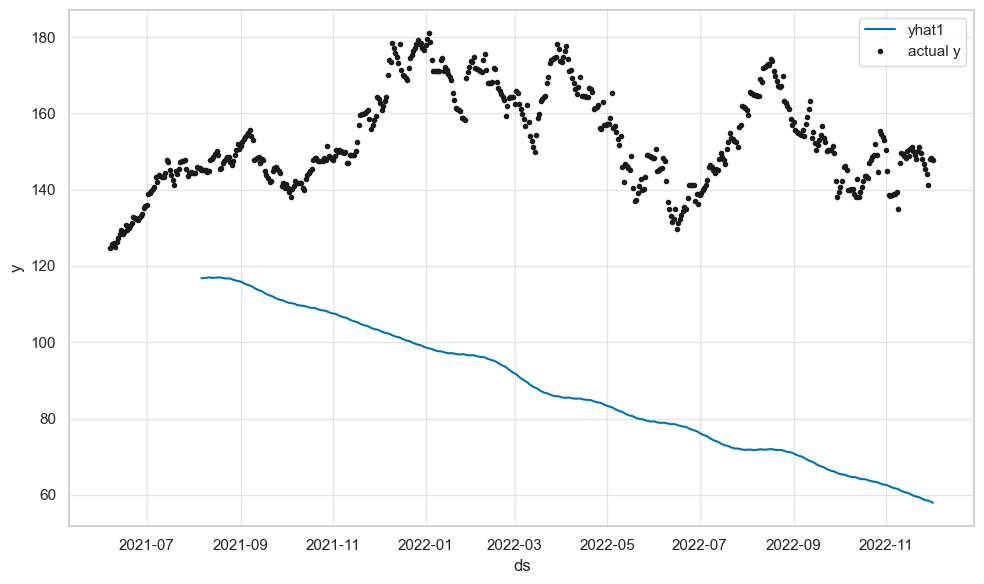

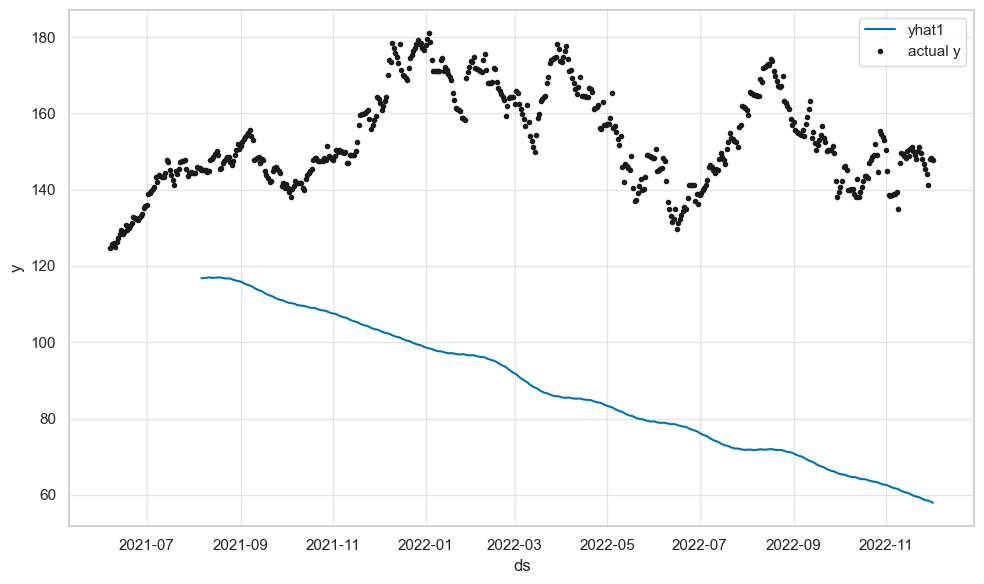

In [22]:
model.plot(test_forecast)